<center> <b> <font size="+2"> MPC Control Applied to an Euler-Bernoulli Beam with piezoelectric actuation
 </font> </b> </center>

<center> <i> Conditions: Free-Free or Clamped-Free </i> </center>
<center> <i> Enviromments: Air or another fluid </i> </center>
<center> <i> Moving Reference </i> </center>


# **Libraries used**

In [ ]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from sympy.solvers import solve, nsolve
from sympy import Symbol, symbols, cos, cosh, sin, sinh
from sympy.interactive import init_printing
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy as sp
import scipy.sparse as sparse
import osqp
import warnings
import sys
import time
from scipy.integrate import ode
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


In [ ]:
init_printing(pretty_print=true)

# **Choice of structure**

*   Beam - Euller Bernoulli = 1
*   Beam - optimized = 0

In [ ]:
choice_structure = 0

# **Design parameters**

In [ ]:
# Parameters - PVC
# Structure                        
L   = 0.40;         # Length                                              [m]
b   = 20e-3;        # Width                                               [m]
h   = 0.3e-3;       # hickness substructure                               [m]
rho = 1340;         # Density                                         [kg/m³]
E   = 3e9;          # Elas. Module of substructure                       [Pa]
m   = b*h*rho       # Mass per length unit without coupled masses      [kg/m]
m1  = L*5*m;        # Concentrated mass  (x=0)                           [kg]
m2  = L*m/5;        # Concentrated mass  (x=L)                           [kg]
I   = b*(h**3)/12;  # Moment of inertia                                  [m4]
E_t = E*I
                    
# Fluid
phoa = 1000         # Density                                         [kg/m³]
cm = 1              # Coefficient of inertia                  [dimensionless]
cd = 20             # Drag coefficient                        [dimensionless]

# MFC M-2814-P1  - d33  
hp = 0.3e-3                       # Piezoelectric fiber thickness         [m]
Lp = 40e-3                        # Total length of the MFC               [m]
coupling = ( 1 +  (h/hp) )*2e-6   # Electromechanical coupling         [Nm/V]

In [ ]:
# Choosing a_al based on resistance of interest

# if choice_structure == 0:
#   ############################## a_al
#   # for the geometry
#   b0_al = b
#   a_al = Symbol('a_al')
#   # for the new material
#   E_choice = E
#   # at the inicial of the struct 
#   E_t_choice = 10*E_t

#   # linear equation for b_al
#   b_al = (b0_al/L)*(L-x)
#   # linear equation for I_al in function of b_al
#   I_al = 2*( b_al*(a_al**3)/12   +  a_al*b_al*(((a_al+h)/2)**2) )
#   # stiffness
#   E_t_al = E_choice * I_al 

#   #roots of
#   function_a = E_t_al.subs(x,0) - E_t_choice
#   # https://www.wolframalpha.com/input/?i=y%3D+10000000*x%5E3+%2B+30000000*x*%28x+%2B+0.0005%29%5E2+-+E_t_choice



In [ ]:
#Choosing resistance based on a_al of interest
if choice_structure == 0:
  x = Symbol('x')
 
  a_al = 0.1e-3
  b0_al = b
  E_choice = E
  b_al = (b0_al/L)*(L-x)
  I_al = 2*( b_al*(a_al**3)/12   +  a_al*b_al*(((a_al+h)/2)**2) )
  E_t_al = E_choice * I_al 

  E_t_choice = E_t_al.subs(x,0)

In [ ]:
if choice_structure == 0:
  
  ############################## E_t_al as a funtion
  E_t_al = E_t_choice*(-x/L + 1)
  ############################## phi_r_al 
  E_t_all = E_t + E_t_al
  pond = E_t_all/E_t 

  #Parameters - structure
  #New system mass
  rho_s = rho
  A_s = (b*L)/2
  V_s = A_s * a_al
  m_al = ((rho_s * V_s)/L) 
  #New system stiffness
  E_t_m = (Integral(E_t_all,(x,0,L)).doit().evalf())/L
  # Parameters     
  m = m + m_al
  E_t = E_t_m 
  m = float (m)
  E_t = float (E_t)



# **Choice of environmental specifications and boundary conditions**


*   for air = 1
*   for fluid = 0





In [ ]:
choice_environment = 0

if choice_environment == 1:
  A1 = 0
  A2 = 0
else:
    A1 = (np.pi/4)*phoa*b*b*cm
    A2 = (phoa/2)*b*cd
    factormas = ((A1+m)*L)/(b*h*rho*L)
    m1 = factormas*m1
    m2 = factormas*m2
    
m = m + A1


*   clamped - free = 1
*   free - free = 0



In [ ]:
choice_boundary = 1

# **Choice of the number of control points and vibration modes for approximation**


ni = variable that controls the number of points

nm = variable that controls the number of modes

In [ ]:
#alpha = np.array([1])
alpha = np.array([0, 0.25, 0.5, 0.75, 1])
ni = len(alpha)

nm = 5

# **Choice of the Number and position of MFCs**

Here, $ n_{pi} $ MFCs located between the positions of interest are taken:

$ \bullet$ $\alpha_{piezo} L - Lp$ and $\alpha_{piezo} L$.

Where $\alpha_ {piezo} $ is the percentage of the beam where the MFC is placed and $ L_p $ the size of the piezo. Therefore, in other words, $ \alpha_ {piezo} $ represents the percentage of the beam where the *end* of the MFC is placed.

In [ ]:
#Observation: 
#piezo_loc = [Lp/L, (L/2 + Lp/2)/L]  # Positions of piezos (percentage of the beam)
#piezo_loc = [Lp/L]
piezo_loc = [Lp/L, 12/30, 20/30]
npi = len(piezo_loc) # Number of piezos

n_piezos = npi

# **Computation of $\lambda$ values**

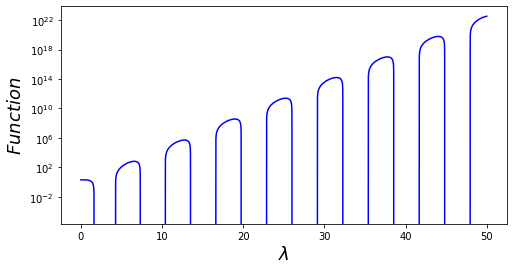

The 5 first values of lambda computed: 

lambda_0 = 1.6163996601559350779
lambda_1 = 4.2670615668647450843
lambda_2 = 7.3183726733425058373
lambda_3 = 10.401562632665816833
lambda_4 = 13.506702248387154204


In [ ]:
lambda_ = np.arange(0,50,0.00001)


kb = lambda_*(m2/(m*L))
ka = lambda_*(m1/(m*L))

free_free = 1 - np.cos(lambda_)*np.cosh(lambda_) + (-np.cos(lambda_)*np.sinh(lambda_)  + np.sin(lambda_)*np.cosh(lambda_))*ka + (-np.cos(lambda_)*np.sinh(lambda_)  + np.sin(lambda_)*np.cosh(lambda_))*kb + 2*np.sinh(lambda_)*np.sin(lambda_)*ka*kb
clamped_free = 1 + np.cos(lambda_)*np.cosh(lambda_) +  kb*(np.cos(lambda_)*np.sinh(lambda_) - np.sin(lambda_)*np.cosh(lambda_) )

func = choice_boundary*(clamped_free) + (1-choice_boundary)*(free_free)

plt.figure(figsize=(8,4))
plt.plot(lambda_,func,color='blue')
plt.grid()
plt.yscale('log')
plt.xlabel('$\lambda$',fontsize=18)
plt.ylabel('$Function$',fontsize=18)
plt.grid()
plt.show()

possible_root = []
for i in range(0,len(func)-1):
  if (func[i]>0 and func[i+1]<0) or (func[i]<0 and func[i+1]>0):
    possible_root.append(lambda_[i])

lambda_ = Symbol('\\lambda')


roots = []
n_roots = nm # Number of roots desired

kb = lambda_*(m2/(m*L))
ka = lambda_*(m1/(m*L))

free_free = 1 - cos(lambda_)*cosh(lambda_) + (-cos(lambda_)*sinh(lambda_)  + sin(lambda_)*cosh(lambda_))*ka + (-cos(lambda_)*sinh(lambda_)  + sin(lambda_)*cosh(lambda_))*kb + 2*sinh(lambda_)*sin(lambda_)*ka*kb
clamped_free = 1 + cos(lambda_)*cosh(lambda_)+ kb*(cos(lambda_)*sinh(lambda_)-sin(lambda_)*cosh(lambda_))

func = choice_boundary*(clamped_free) + (1-choice_boundary)*(free_free)

for i in range(0,n_roots):
 roots.append(nsolve(func, lambda_, possible_root[i], prec=20))

print('The {} first values of lambda computed: '.format(len(roots)))
print('')
for i in range(0,len(roots)):
  print('lambda_{} = {}'.format(i,roots[i]))


# **Computation of the functions of modes $\Phi_r$**

In [ ]:
x = Symbol('x')

Beta =  Symbol('Beta')
lambd_ = Symbol('lambd_')
L_B = Symbol('L_B')
Beta = lambd_ /L_B


Q = cosh(Beta*x) + cos(Beta*x)
R = sinh(Beta*x) + sin(Beta*x)
S = cosh(Beta*x) - cos(Beta*x)
T = sinh(Beta*x) - sin(Beta*x)

Cr = 1

kb = lambd_ * m2 /(L*m)
ka = lambd_ * m1 /(L*m)

phi_clamped_free = Cr*(-S + T*((T.subs(x,L_B)+kb*S.subs(x,L_B))/(Q.subs(x,L_B)+kb*T.subs(x,L_B))))

f1 = (cos(lambd_) +cosh(lambd_))*kb + 2*(cosh(lambd_))*ka + 2*(sinh(lambd_))*ka*kb
f2 = (sin(lambd_) + sinh(lambd_))*kb
phi_free_free  =   Cr*((-((S.subs(x,L_B)) + f2)/(R.subs(x,L_B) + f1))*(Q)  +  (sin(Beta*x))  +    ((-2*ka*((S.subs(x,L_B)+f2)/(R.subs(x,L_B) + f1)))+(1))*(sinh(Beta*x)) )


phi = choice_boundary*phi_clamped_free +  (1-choice_boundary)*phi_free_free



print('Expression for phi:')
print(phi)
phi

phi_r1 = []
for i in range(0,len(roots)):
  phi_r1.append(phi.subs(lambd_,roots[i]))

phi_r = []
for i in range(0,len(roots)):
  phi_r.append(phi_r1[i].subs(L_B,L))

print("\n")


print('Numeric expressions for phi:')
print(phi_r)



Expression for phi:
(-sin(lambd_*x/L_B) + sinh(lambd_*x/L_B))*(0.2*lambd_*(-cos(lambd_) + cosh(lambd_)) - sin(lambd_) + sinh(lambd_))/(0.2*lambd_*(-sin(lambd_) + sinh(lambd_)) + cos(lambd_) + cosh(lambd_)) + cos(lambd_*x/L_B) - cosh(lambd_*x/L_B)


Numeric expressions for phi:
[-0.75244194252634073152*sin(4.0409991503898376947*x) + cos(4.0409991503898376947*x) + 0.75244194252634073152*sinh(4.0409991503898376947*x) - cosh(4.0409991503898376947*x), -1.0139795513098749171*sin(10.667653917161862711*x) + cos(10.667653917161862711*x) + 1.0139795513098749171*sinh(10.667653917161862711*x) - cosh(10.667653917161862711*x), -0.9995376781383831998*sin(18.295931683356264593*x) + cos(18.295931683356264593*x) + 0.9995376781383831998*sinh(18.295931683356264593*x) - cosh(18.295931683356264593*x), -1.0000163505157465456*sin(26.003906581664542081*x) + cos(26.003906581664542081*x) + 1.0000163505157465456*sinh(26.003906581664542081*x) - cosh(26.003906581664542081*x), -0.99999940562376731281*sin(33.76675562

In [ ]:
# Computing and coupling Cr:

Cr = []

for i in range (0, len(roots)):

  integral  = integrate(phi_r[i]*phi_r[i], (x, 0, L))
  phi_r_L= phi_r[i].subs(x,L)
  phi_r_0= phi_r[i].subs(x,0)

  RR = 1 / (m*integral + m2*phi_r_L*phi_r_L + m1*phi_r_0*phi_r_0)
  RR = RR**0.5
  Cr.append(RR)

for i in range (0, len(roots)):
  phi_r[i] = Cr[i]*phi_r[i]


print("\n")
print("\n")
print("\n")


In [ ]:
if choice_structure == 0:
  for i in range (len(phi_r)):
    phi_r[i] = phi_r[i]/pond

# **Graphical analysis of vibration modes $\Phi_r$**

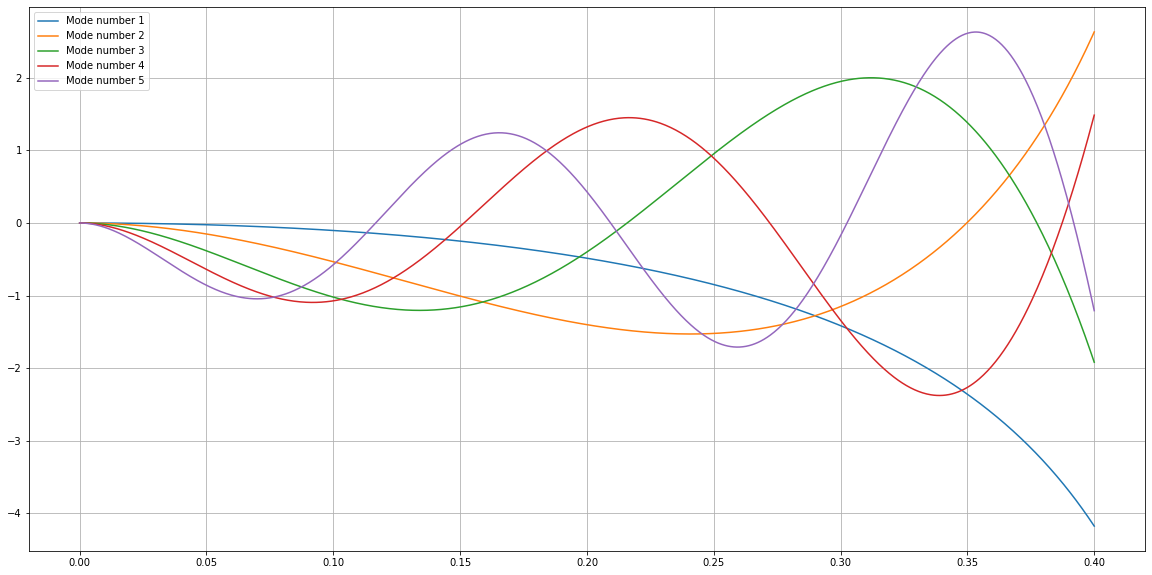

In [ ]:
# Discretizing the length of the bar
discre = 1000
i = np.linspace(0, L,discre)
ii = 0

plt.figure(figsize=(20,10))

for ii in range (0, len(roots)):
  PHI_R = []
  for j in range (0, len(i)):
    aux = phi_r[ii].subs(x,i[j])
    PHI_R.append(aux)

  PHI_R = np.array(PHI_R)
  i = np.array(i)
  plt.plot(i,PHI_R,label='Mode number {}'.format(ii+1))

plt.legend()
plt.grid()

# **Graphical analysis of of the first derivative of $\Phi$**

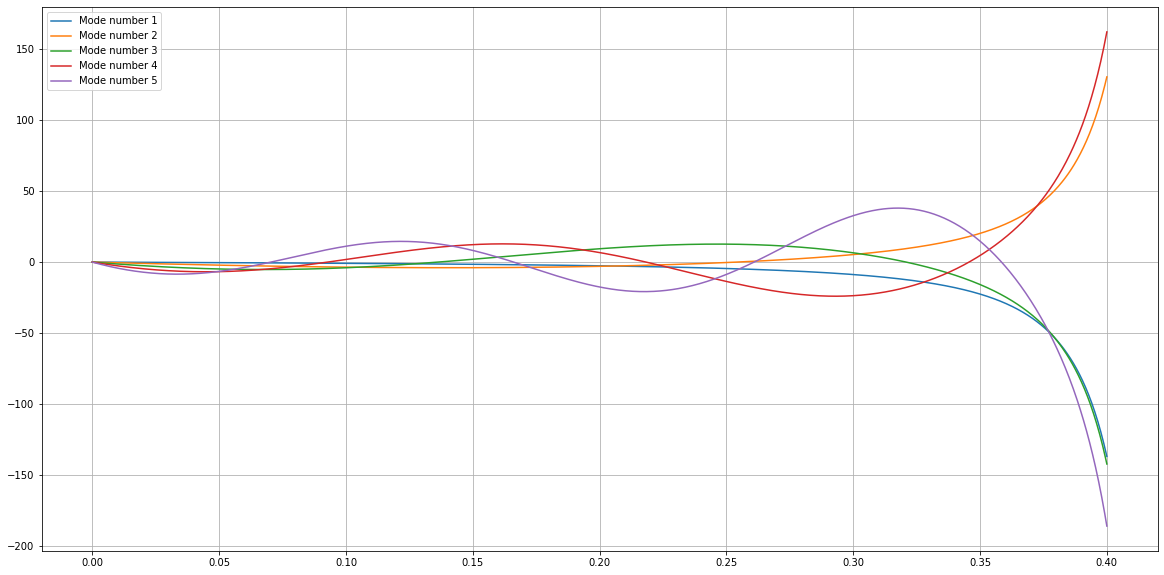

In [ ]:
import sympy as sy
dphi_r = []
for i in range (len(phi_r)):
  dphi_r.append(sy.diff(phi_r[i]))

# Discretizing the length of the bar
i = np.linspace(0, L,discre)
ii = 0

plt.figure(figsize=(20,10))

for ii in range (0, len(roots)):
  DPHI_R = []
  for j in range (0, len(i)):
    aux = dphi_r[ii].subs(x,i[j])
    DPHI_R.append(aux)

  DPHI_R = np.array(DPHI_R)
  i = np.array(i)
  plt.plot(i,DPHI_R,label='Mode number {}'.format(ii+1))

plt.legend()
plt.grid()


# **Defining $\alpha$ according to the point of interest ($0\leq\alpha\leq1 $)**

In [ ]:
# We will consider several different measurement points
xnum = alpha*L

phi_r_num = np.zeros((len(alpha),len(roots)))

for i in range(0,len(roots)):
  for cont in range(0,len(alpha)):
    phi_r_num[cont,i] = phi_r[i].subs(x,xnum[cont])


        
print('Values of Phi_r:')
print('')

phi_r_num

Values of Phi_r:



array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.03921788, -0.20272736, -0.38796179, -0.40741464, -0.2184771 ],
       [-0.19886575, -0.57426943, -0.16367298,  0.5419517 ,  0.17610082],
       [-0.6858324 , -0.55818843,  0.94509875, -0.64980647, -0.0848977 ],
       [-4.16626418,  2.62619342, -1.91414853,  1.48187647, -1.20503827]])

# **Calculation of modal parameters**

 Expressions in modal form

Now, let's write our general equation of motion in the modal domain, as follows:



$\ddot{\eta}_{r}(t)+\left(2 \zeta_{r} \omega_{r}+\kappa_r\left|\dot{\eta}_{r}(t)\right|\right) \dot{\eta}_{r}(t)+\omega_{r}^{2} \eta_{r}(t)=f_r$

where:

$\omega_r = \lambda_r^2.\sqrt{ \left(\dfrac{E_t}{(m+A_1).L^4} \right) } $

$2\zeta_{r}\omega_{r} = \dfrac{c_sI\omega_{r}^2}{E_t} + \dfrac{c_a(1- m_1\phi_{r}(0)^2 - m_2\phi_{r}(L)^2)}{m+A_1}$

$\kappa_r = A_2 \int_{0}^{L}  \left|\phi_{r}(x)\right|\phi_{r}(x)^2 dx$


$f_r = \sum\limits_{i=1}^{npi}\theta_{ri}V_i(t)$

with $ C_s $ being the damping coefficient related to internal dissipation, $ C_a $ related to air dissipation, $E_t$  the 
mechanical stiffness, $ m $ the 
mass per unit length of the beam , $ L $ the length and $ f_r $ the excitation force applied.

$ f_r $ will be detailed in the next blocks



In [ ]:
omega_r = np.zeros(len(roots))

for i in range(0,len(roots)):
    omega_r[i] = roots[i]**2 * np.sqrt((E_t) / ((m)*L**4) )

wr = omega_r 

In [ ]:
if choice_environment == 1:
  k_r = np.zeros(len(roots))

if choice_environment == 0:
  k_r = np.ones(len(roots))

  for i in range (0, len(roots)):

   #k_r[i] = A2*integrate(phi_r[i]*phi_r[i]*abs(phi_r[i]), (x, 0, L))
   #5 modos, engastado livre
   k_r = [1181.79480924, 1885.56166077, 2120.81629944, 2217.54833984, 2264.9609375 ]


In [ ]:
if choice_environment == 1:  
  # Taking the first zetas as being
  zeta0 = 0.010 #associated to omega_r[0]
  zeta1 = 0.012 #associated to omega_r[1]

  Et = E_t

  wj = omega_r[0]
  wk = omega_r[1]

  fj = 1- m1*(phi_r[0].subs(x,0))**2 - m2*((phi_r[0].subs(x,L))**2)
  fk = 1- m1*(phi_r[1].subs(x,0))**2 - m2*((phi_r[1].subs(x,L))**2)

  M1 = -(2*Et*fk*wj)/(- fk*wj**2 + fj*wk**2)
  M2 = (2*Et*fj*wk)/(- fk*wj**2 + fj*wk**2)
  M3 = (2*wj*wk**2*(m))/(- fk*wj**2 + fj*wk**2)
  M4 = -(2*wj**2*wk*(m))/(- fk*wj**2 + fj*wk**2)


  Maux = [[M1,M2] , [M3,M4] ]

  # Internal dissipation coefficient
  cs = ((M1*zeta0) + (M2*zeta1))/I  

  # External dissipation coefficient
  ca = ((M3*zeta0) + (M4*zeta1))

  zeta_r = np.zeros(len(roots))
  for i in range(0,len(roots)):
    zeta_r[i] = ( (cs*I*omega_r[i]**2)/(E_t)  + (ca*(1- m1*(phi_r[i].subs(x,0))**2 - m2*((phi_r[i].subs(x,L))**2)))/(m) ) / (2*omega_r[i])
  n = len(roots)

In [ ]:

if choice_environment == 0:  

  cs = 1396219.2029575329548
  
  zeta_r = np.zeros(len(roots))
  for i in range(0,len(roots)):
    zeta_r[i] = ( (cs*I*omega_r[i]**2)/(E_t)  + (0.001*A2*(1- m1*(phi_r[i].subs(x,0))**2 - m2*((phi_r[i].subs(x,L))**2)))/(m) ) / (2*omega_r[i])
  n = len(roots)

In [ ]:
#ca = 0.0026146982694404338298

In [ ]:
0.05*A2

# **Calculation of $\tilde{\theta}_i$**

In [ ]:
# n_modes = nm
# n_piezos = npi

# theta = np.zeros((n_modes,n_piezos))

# #Discretizing the length of the bar
# comp_discret = discre
# Ll = L
# i = np.linspace(0, Ll,comp_discret)

# for ii in range (0, nm):
#   for cont_piezo in range(0,n_piezos):
#     theta[ii,cont_piezo] = coupling*(dPHI_R[np.int(piezo_loc[cont_piezo]*comp_discret),ii] - dPHI_R[np.int(piezo_loc[cont_piezo]*comp_discret-Lp*comp_discret/Ll),ii])


In [ ]:
n_modes = nm
n_piezos = npi

theta = np.zeros((n_modes,n_piezos))

#Discretizing the length of the bar
comp_discret = discre
Ll = L
i = np.linspace(0, Ll,comp_discret)

for ii in range (0, nm):
  for cont_piezo in range(0,n_piezos):
    theta[ii,cont_piezo] = coupling*( dphi_r[ii].subs(x,piezo_loc[cont_piezo]*L)  -   dphi_r[ii].subs(x,(piezo_loc[cont_piezo]*L - Lp))  )

# **State space definition**

In [ ]:
n_modes = nm
n_points = ni
vel = 0

In [ ]:
A = np.zeros((2*n_modes*n_points ,2*n_modes*n_points))
#Filling in the 0 and 1 lines
i=0
while i < 2*n_modes*n_points:
  j = 0
  while j < 2*n_modes*n_points:
    if (j % 2 == 0):
      A[i][j] = 0
    else:
      if (i+1) == j:
        A[i][j] = 1
    j = j+1
  i = i + 1


#Filling the lines of wr and zetas
i=1
aux = 0
while i < 2*n_modes*n_points:

  if aux >= len(wr):
    aux = 0
  j = 0
  while j < 2*n_modes*n_points:
    if (j % 2 == 0):
      A[i][j] = 0
    else:
      if i == j:
        A[i][j] = -(2*zeta_r[aux]*omega_r[aux] + k_r[aux]*vel )
        A[i][j-1] = -omega_r[aux]**2  
        aux = aux+1
    j = j+1

  i = i + 1

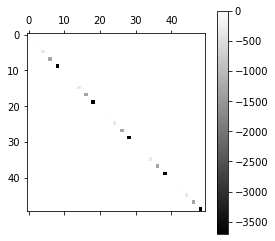

In [ ]:
plt.matshow(A,cmap='gray')
plt.colorbar()
#plt.title('Matrix A')
plt.show()

In [ ]:
#Matrix B
B = np.zeros((2*n_modes*n_points , n_piezos))
#Filling in the 0 lines
i=0
while i < 2*n_modes*n_points:
  j = 0
  while j < n_piezos:
    if (i % 2 == 0):
      B[i][j] = 0
    j = j+1
  i = i + 1

#Filling the coupling lines
k1 = 0
k2 = 0
k3 = 0
aux = []

for k1 in range(0,n_points):
  for k2 in range(0,len(wr)):
    for k3 in range (0,n_piezos):
      aux.append(-phi_r_num[k1][k2]*theta[k2][k3])
n_aux = len(aux)

i=0
count = 0
while i < 2*n_modes*n_points:
  j = 0
  if (i % 2 != 0):
    while j < n_piezos:
      B[i][j] = aux[j+count]
      j = j+1
    count = count+npi
  i = i + 1

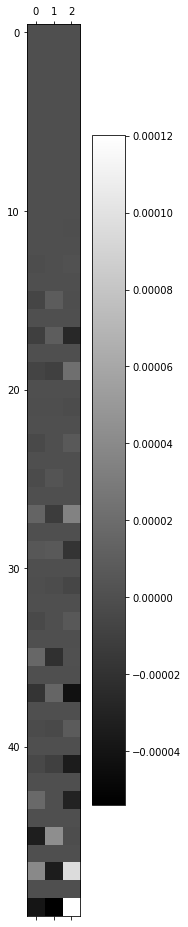

In [ ]:
plt.matshow(B,cmap='gray')
plt.colorbar()
#plt.title('Matrix B')
plt.show()

In [ ]:
#Matrix C
C = np.zeros((n_points,2*n_modes*n_points ))

i = 0
count = 0
while  i < n_points:
  j = 0

  while j < 2*n_modes*n_points:
    if (j % 2 == 0) and (j+count<len(C[i]) and (j<n_modes*n_points - (n_points - 2)*n_modes)):
       C[i][j+count] = 1
    j = j + 1

  count = count + 2*n_modes 

  i = i + 1

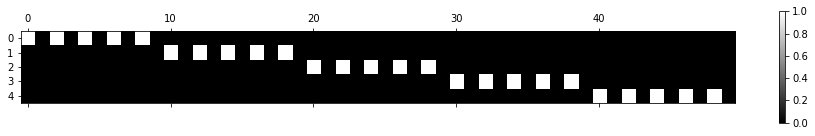

In [ ]:
plt.matshow(C,cmap='gray')
plt.colorbar()
#plt.title('Matrix C')
plt.show()

In [ ]:
C_m = np.identity(2*nm*ni)

In [ ]:
D_m = np.zeros((2*nm*ni , n_piezos))

In [ ]:
D = []
for auxid1 in range (n_points):
  vetord = []
  for auxid in range(npi):
    vetord.append(0)
  D.append(vetord)    

# PARA POR NO MATLAB

In [ ]:
print("PARA A MATRIZ A")
print("\n")

MATRIX = A
vaxi1 = len(MATRIX)
vaxi2 = len(MATRIX[0])


for i in range(0,vaxi1):
  if i == 0:
     print("[", end="")
  if i != 0:
    print(";")
  for j in range (0,vaxi2):
    print(MATRIX[i][j] , end="")
    print("    ", end="")
print("]")


print("\n")
print("\n")

print("PARA A MATRIZ B")
print("\n")

MATRIX = B
vaxi1 = len(MATRIX)
vaxi2 = len(MATRIX[0])


for i in range(0,vaxi1):
  if i == 0:
     print("[", end="")
  if i != 0:
    print(";")
  for j in range (0,vaxi2):
    print(MATRIX[i][j] , end="")
    print("    ", end="")
print("]")

print("\n")
print("PARA A MATRIZ C_m")
print("\n")

MATRIX = C_m
vaxi1 = len(MATRIX)
vaxi2 = len(MATRIX[0])


for i in range(0,vaxi1):
  if i == 0:
     print("[", end="")
  if i != 0:
    print(";")
  for j in range (0,vaxi2):
    print(MATRIX[i][j] , end="")
    print("    ", end="")
print("]")

print("\n")
print("PARA A MATRIZ D_m")
print("\n")

MATRIX = D_m
vaxi1 = len(MATRIX)
vaxi2 = len(MATRIX[0])


for i in range(0,vaxi1):
  if i == 0:
     print("[", end="")
  if i != 0:
    print(";")
  for j in range (0,vaxi2):
    print(MATRIX[i][j] , end="")
    print("    ", end="")
print("]")


print("\n")
print("PARA A MATRIZ C")
print("\n")

MATRIX = C
vaxi1 = len(MATRIX)
vaxi2 = len(MATRIX[0])


for i in range(0,vaxi1):
  if i == 0:
     print("[", end="")
  if i != 0:
    print(";")
  for j in range (0,vaxi2):
    print(MATRIX[i][j] , end="")
    print("    ", end="")
print("]")


print("\n")
print("PARA A MATRIZ D")
print("\n")

MATRIX = D
vaxi1 = len(MATRIX)
vaxi2 = len(MATRIX[0])


for i in range(0,vaxi1):
  if i == 0:
     print("[", end="")
  if i != 0:
    print(";")
  for j in range (0,vaxi2):
    print(MATRIX[i][j] , end="")
    print("    ", end="")
print("]")

PARA A MATRIZ A


[0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    ;
-0.7592324728212779    -0.3379407651290785    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    ;
0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

In [ ]:
wr

array([ 0.87133947,  6.07222289, 17.86154117, 36.081706  , 60.8399066 ])

In [ ]:
theta

array([[-1.16949512e-06, -2.43374817e-06, -8.26818958e-06],
       [-7.08228335e-06, -4.41283896e-08,  1.17235444e-05],
       [-1.71761477e-05,  2.24051084e-05, -5.28471200e-07],
       [-2.69352496e-05,  2.34518894e-05, -6.46442058e-05],
       [-3.27058515e-05, -4.47388667e-05,  9.97090494e-05]])